In [1]:
#!/usr/bin/python3.7

'''
Script for X-Ray reflectivity data reduction

author - Herr dr. Nebojsa Zec
e-mail - nebojsa.zec@hzg.de
python_version - 3.7
'''

import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Functions for loading parameters and .xrdml files
def get_parameters(filename):
    '''Loading parameters from a .txt file
    
    Filename: .txt file containg four parameters separated by new row:
        
    Primary beam intensity (counts per second): float
    Sample length (mm): float
    Beam height (mm): float
    Wavelength (A^-1): float
        (CuKAlpha=1.5406; MoKAlpha=0.7017)
    '''
    from pathlib import Path
    
    params = Path('./' + filename)
    
    if params.exists():
        params = np.loadtxt('./' + filename)
        return params[0], params[1], params[2], params[3]
    else:
        raise ValueError('Missing file:' + filename)

def get_xrdml_files():
    '''Loading .xrdml files 

    This function loads .xrdml files
    Since complete q range is often divided in several scans
    it is necessary to put reflectivity and background files
    in two separate folders named "xrrdata" and "background"    
    '''
    import glob
    
    xrr_files = sorted(glob.glob('./xrrdata/*.xrdml'))
    background_files = sorted(glob.glob('./background/*.xrdml'))

    return xrr_files, background_files

In [3]:
#Classes and Functions for reading and calculating reflectivity and background data
class read_xrdml():
    '''This class reads .xrdml files and extracts: 
    
    attenuation factors: numpy array
    intensities: numpy array
    counting time: float
    start and end points for 2theta and omega: floats
    '''

    def __init__(self, files):
        self.files = files 
        self.tree = ET.parse(self.files)
        self.root = self.tree.getroot()
        self.ns = {'line' : "http://www.xrdml.com/XRDMeasurement/1.5"} #defining new/shorter NameSpace in xml file
        
    def get_intensity(self):
        attenuation_factors = []
        intensities = []
        for i in self.root.findall('line:xrdMeasurement/line:scan/line:dataPoints/line:beamAttenuationFactors', self.ns):
            attenuation_factors.append(np.array(list(map(float, i.text.split()))))
        for i in self.root.findall('line:xrdMeasurement/line:scan/line:dataPoints/line:intensities', self.ns):
            intensities.append(np.array(list(map(float, i.text.split()))))
        return attenuation_factors, intensities    

    def get_counting_time(self):
        counting_time = float(self.root.find('line:xrdMeasurement/line:scan/line:dataPoints/line:commonCountingTime', self.ns).text)
        return counting_time

    def get_angle_range(self):
        two_theta_start = float(self.root.find('line:xrdMeasurement/line:scan/line:dataPoints/line:positions[1]/line:startPosition', self.ns).text)
        two_theta_end = float(self.root.find('line:xrdMeasurement/line:scan/line:dataPoints/line:positions[1]/line:endPosition', self.ns).text)
        omega_start = float(self.root.find('line:xrdMeasurement/line:scan/line:dataPoints/line:positions[2]/line:startPosition', self.ns).text)
        omega_end = float(self.root.find('line:xrdMeasurement/line:scan/line:dataPoints/line:positions[2]/line:endPosition', self.ns).text)
        return two_theta_start, two_theta_end, omega_start, omega_end

def calculate_data(attenuation_factors, 
                   intensities, 
                   counting_time,
                   two_theta_start, 
                   two_theta_end, 
                   omega_start, 
                   omega_end):
    
    # Calculate 2Theta and Omega
    num_of_repetitions = len(intensities)
    num_of_points = len(intensities[0])
  
    step_size_twotheta = (two_theta_end-two_theta_start) / (num_of_points-1)
    step_size_omega = (omega_end-omega_start) / (num_of_points-1)
    
    xAxis_twotheta = []
    for i in range(num_of_points):
        xAxis_twotheta.append(two_theta_start + step_size_twotheta*i)
    
    xAxis_omega = []
    for i in range(num_of_points):
        xAxis_omega.append(omega_start + step_size_omega*i)
    
    two_theta = np.array(xAxis_twotheta)
    omega = np.array(xAxis_omega)
        
    # Calculate counts per second
    counts = 0
    for i in range(0,num_of_repetitions):
        counts += intensities[i]
    cps = (counts/(num_of_repetitions*counting_time))
    
    # Calculate errors
    num_of_photons = np.array(intensities)/np.array(attenuation_factors)
    error_photons = np.sqrt(num_of_photons)
    sqr_err = 0
    for i in range(0,num_of_repetitions):
        sqr_err += np.square(error_photons[i])
    st_dev = np.sqrt(sqr_err)
    err_counts = (st_dev*np.array(attenuation_factors[0]))
    return two_theta, omega, cps, err_counts

def raw_reflectivity(input_files, output_files):
    '''
    From each .xrdml file measured data will be 
    read and forwarded to calculate_data function  
    which will return 2theta, omega, counts per second
    and errors
    '''
    two_theta = []
    omega = []
    cps = []
    err_counts = []

    for f in input_files:
        print(f)
        #Use read_xrdm class to get values from .xrdml file
        read_data = read_xrdml(f)
        attenuation_factors, intensities = read_data.get_intensity()
        counting_time = read_data.get_counting_time()
        two_theta_start, two_theta_end, omega_start, omega_end = read_data.get_angle_range()
        
        #Forward these values to calculate_data function to get reflectivity and errors
        data = calculate_data(attenuation_factors, 
                              intensities, 
                              counting_time,
                              two_theta_start, 
                              two_theta_end, 
                              omega_start, 
                              omega_end)

        two_theta.append(data[0])
        omega.append(data[1])
        cps.append(data[2])
        err_counts.append(data[3])

    two_theta = np.concatenate(two_theta)
    omega = np.concatenate(omega) 
    cps = np.concatenate(cps) 
    err_counts = np.concatenate(err_counts)
    q = 4*np.pi/wavelength*np.sin(two_theta/2*np.pi/180)

    sep=' '
    np.savetxt(output_files + '.txt', np.transpose([q, two_theta, omega, cps, err_counts]),
               header='qz / A^-1'+sep*14
                     +'2theta / degree'+sep*10
                     +'omega'+sep*20
                     +'Counts Per Second'+sep*8
                     +'Error')
    return q, two_theta, omega, cps, err_counts

In [4]:
# Function for reducing reflectivity data 
def reduced_reflectivity():
     
    #correcting for background
    background_corrected = (cps - bk_cps)
    error = np.sqrt(err_counts**2 + bk_err_counts**2)
    
    #correcting for the primary beam
    prim_int_background_corrected = background_corrected/primary_beam
    prim_int_error = error/primary_beam

    #correction for the footprint
    footprint_prim_int_background_corrected = prim_int_background_corrected
    footprint_prim_int_error = prim_int_error

    x = beam_height*4*np.pi/wavelength/q
    footprint_prim_int_background_corrected[x>=sample_size]=(footprint_prim_int_background_corrected*(x/sample_size))[x>=sample_size]
    footprint_prim_int_error[x>=sample_size]=(footprint_prim_int_error*(x/sample_size))[x>=sample_size]
    
    sep=' '
    np.savetxt('reduced_reflectivity.txt', 
               np.transpose([q, two_theta, omega, footprint_prim_int_background_corrected, footprint_prim_int_error]),
               header='qz / A^-1'+sep*14
                     +'2theta / degree'+sep*10
                     +'omega'+sep*20
                     +'Reduced Reflectivity'+sep*5
                     +'Error')


In [5]:
# 1. Step - load parameters and xrdml files
primary_beam, sample_size, beam_height, wavelength = get_parameters('parameters.txt')
xrr_files, background_files = get_xrdml_files()

# 2. Step - use xrr_files and background_files to get q, angles, cps and error
q,two_theta, omega, cps, err_counts = raw_reflectivity(xrr_files, 'raw_xrr')
bk_q, bk_two_theta, bk_omega, bk_cps, bk_err_counts = raw_reflectivity(background_files, 'background')

# 3. Step - perform data reduction
reduced_reflectivity() 

# 4. Step - plot the data

./xrrdata/xrrdataSi-Cu 2 long center XRR Cu step 1 untilted Omega-2Th range 0-0_4deg 20min.xrdml
./xrrdata/xrrdataSi-Cu 2 long center XRR Cu step 2 untilted Omega-2Th range 0_38-0_5deg 26min.xrdml
./xrrdata/xrrdataSi-Cu 2 long center XRR Cu step 3 untilted Omega-2Th range 0_48-1deg 2_5h.xrdml
./xrrdata/xrrdataSi-Cu 2 long center XRR Cu step 4 untilted Omega-2Th range 0_98-2deg 4h.xrdml
./xrrdata/xrrdataSi-Cu 2 long center XRR Cu step 5 untilted Omega-2Th range 1_98-3_5deg 4h.xrdml
./background/backSi-Cu 2 long center XRR Cu step 1 tilted Omega-2Th range 0-0_4deg 20min.xrdml
./background/backSi-Cu 2 long center XRR Cu step 2 tilted Omega-2Th range 0_38-0_5deg 26min.xrdml
./background/backSi-Cu 2 long center XRR Cu step 3 tilted Omega-2Th range 0_48-1deg 2_5h.xrdml
./background/backSi-Cu 2 long center XRR Cu step 4 tilted Omega-2Th range 0_98-2deg 4h.xrdml
./background/backSi-Cu 2 long center XRR Cu step 5 tilted Omega-2Th range 1_98-3_5deg 4h.xrdml


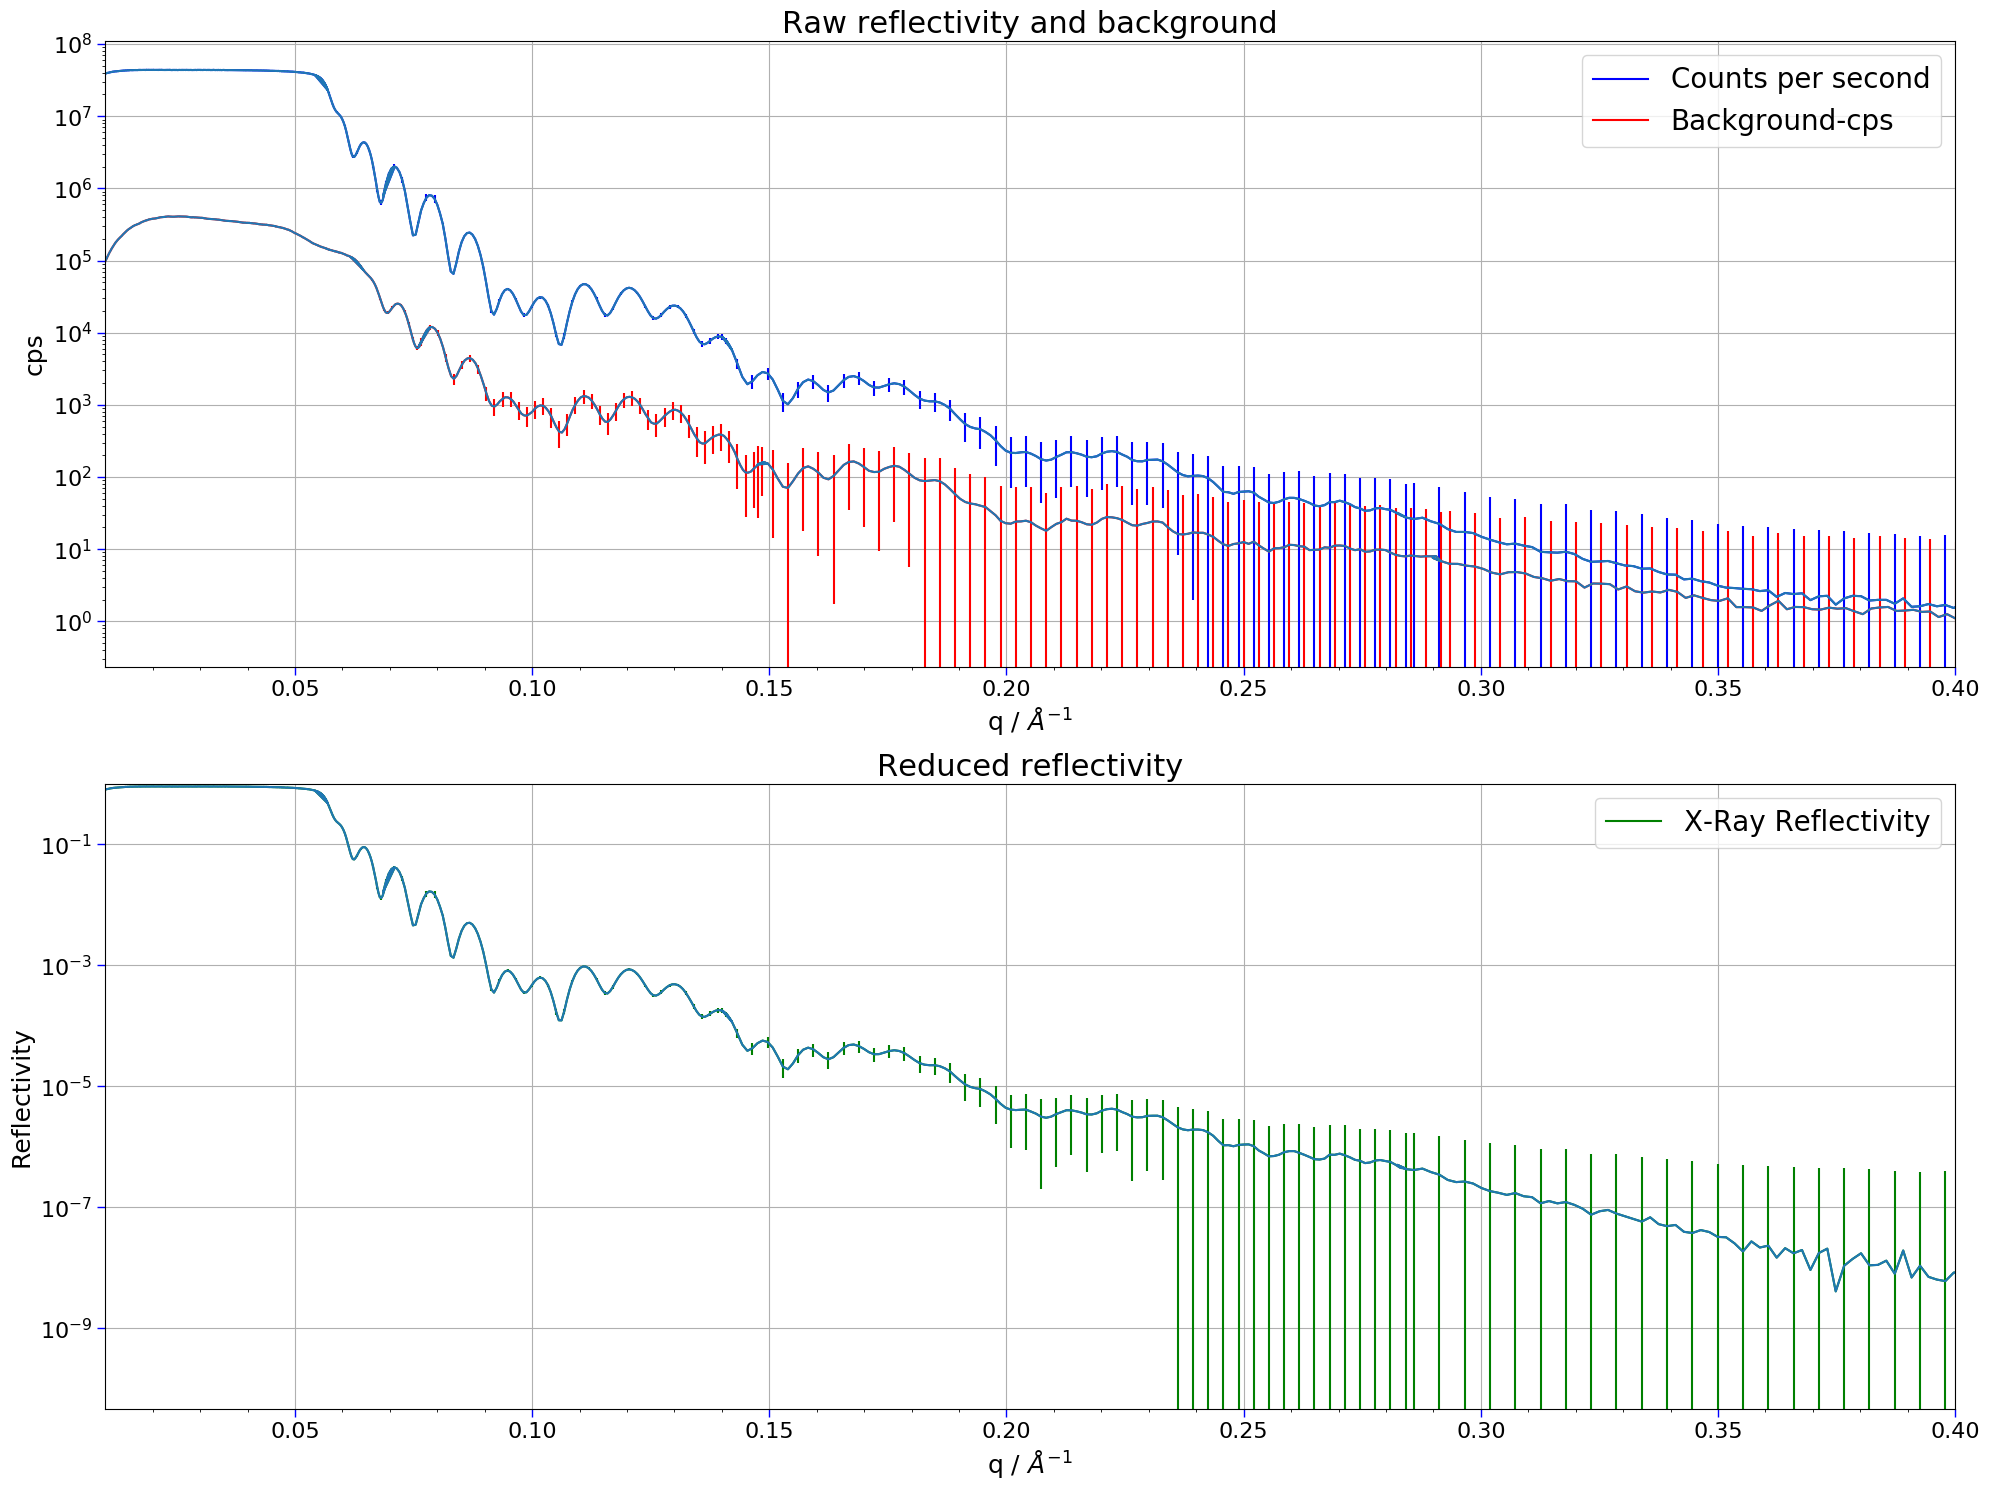

In [6]:
def plotting(data, lab, clr):
    x,y,z = np.loadtxt(data, unpack=True, usecols=(0,3,4))
    plt.errorbar(x,y, yerr = z, errorevery=3, animated=True, ecolor=clr)
    plt.semilogy(x,y, label=lab, color=clr)

plt.subplots(figsize=(20, 15), dpi=100, facecolor='w', edgecolor='g', num='X-Ray Reflectivity')
plt.subplots_adjust(hspace=0.45)

plt.subplot(2,1,1)
plotting('raw_xrr.txt', 'Counts per second', 'b')
plotting('background.txt', 'Background-cps', 'r')
plt.xlabel('q / $\AA^{-1}$', fontsize = 18)  # or 2$\dot{\\omega}$ / $^\circ$ or 2$\dot{\\theta}$ / $^\circ$
plt.ylabel('cps', fontsize = 18)
plt.title('Raw reflectivity and background', fontsize = 22)                                        	
plt.minorticks_on()
plt.xlim(0.01, 0.4)
plt.tick_params(axis='both', which='major', direction='out', length=6, width=1, labelsize=16, color='b')
plt.grid(which='major')
plt.legend(fontsize=20)

plt.subplot(2,1,2)
plotting('reduced_reflectivity.txt', 'X-Ray Reflectivity', 'g')
plt.xlabel('q / $\AA^{-1}$', fontsize = 18)
plt.ylabel('Reflectivity', fontsize = 18)
plt.title('Reduced reflectivity', fontsize = 22)
plt.minorticks_on()
plt.xlim(0.01, 0.4)
plt.ylim(top=1)
plt.tick_params(axis='both', which='major', direction='out', length=6, width=1, labelsize=16, color='b')
plt.grid(which='major')
plt.legend(fontsize=20)

plt.tight_layout()
plt.show()